In [30]:
import os
import numpy as np
import time
import copy
import sys
import pickle

import matplotlib
import matplotlib.pyplot as plt

ang_2_bohr = 1.0/0.52917721067
hart_2_ev = 27.21138602

import cp2k_utilities as cu

In [31]:
folder = "/home/kristjan/local_work/cnt120-periodic-single-vac/"

file_cp2k_inp = folder + "cp2k.inp"
file_cp2k_out = folder + "cp2k.out"

file_basis_set = folder + "BR"
file_xyz = folder + "cnt120-single-vac-periodic.xyz"

file_restart = folder + "restart_sel_morbs.wfn"

#file_molog = folder + "morbs/PROJ-COEFF-1_0.MOLog"
#file_pickle = folder + "pickled.bin"

In [32]:
emin = -2.0 # eV
emax =  2.0 # eV

In [33]:
time1 = time.time()
elem_basis_names, cell = cu.read_cp2k_input(file_cp2k_inp)
print("Read cp2k input: %.3f" % (time.time()-time1))

time1 = time.time()
fermi = cu.read_fermi_from_cp2k_out(file_cp2k_out)
print("Read cp2k out: %.3f" % (time.time()-time1))

time1 = time.time()
at_positions, at_elems = cu.read_atoms(file_xyz)
print("Read xyz: %.3f" % (time.time()-time1))

time1 = time.time()
basis_sets = cu.read_basis_functions(file_basis_set, elem_basis_names)
print("Read basis sets: %.3f" % (time.time()-time1))


# MOLOG FILE

#time1 = time.time()
#morb_composition_molog, morb_energies_molog = cu.read_and_process_molog(file_molog)
#print("Read molog: %.3f" % (time.time()-time1))
#
#def select_morbs(morb_composition, morb_energies):
#    sel_morb_composition = []
#    sel_morb_energies = []
#    for i_mo, morb in enumerate(morb_composition):
#        energy = morb_energies[i_mo]
#        if energy > emin and energy < emax:
#            sel_morb_energies.append(energy)
#            sel_morb_composition.append(morb)
#            
#    print("Selected mol. orbitals %d/%d" % (len(sel_morb_composition), len(morb_composition)))
#    return sel_morb_composition, np.array(sel_morb_energies)
#
#morb_composition_molog, morb_energies_molog = select_morbs(morb_composition_molog, morb_energies_molog)

# RESTART FILE

time1 = time.time()
morb_composition, morb_energies, morb_occs, ref_en, i_homo = cu.load_restart_wfn_file(file_restart, emin, emax, fermi)
print("Found %d orbitals" % len(morb_energies))
print("Read restart: %.3f" % (time.time()-time1))

# PICKLED FILE

#time1 = time.time()
#with open(file_pickle, 'rb') as handle:
#    morb_composition_pic, morb_energies_pic, morb_occs_pic = pickle.load(handle)
#print("Read pickle: %.3f" % (time.time()-time1))

Read cp2k input: 0.001
Read cp2k out: 0.001
Read xyz: 0.093
Read basis sets: 0.002
First molecular index in energy range:  0
Found 1048 orbitals
Read restart: 237.458


In [34]:
height = 1.0 # Plane distance in z direction from topmost atom; angstroms

# Define real space grid
# Cp2k chooses close to 0.08 angstroms (?)
step = 0.0852 # Good to choose a factor of the lattice parameter 4.26
step *= ang_2_bohr
cell_n = (np.round(cell/step)).astype(int)

# !!! NB: Redefine cell such that step stays the same (and a factor of lattice param)
cell = cell_n*step

cu.center_atoms_to_cell(at_positions, cell)

In [35]:
# Define the plane

time1 = time.time()

carb_positions = at_positions[np.array(at_elems)[:, 0] == 'C']

plane_z = np.max(carb_positions[:, 2]) + height*ang_2_bohr

dv = cell[0:2]/cell_n[0:2]
x_arr = np.arange(0, cell[0], dv[0])
y_arr = np.arange(0, cell[1], dv[1])
x_grid, y_grid = np.meshgrid(x_arr, y_arr, indexing='ij')

# Define small grid for orbital evaluation
# and convenient PBC implementation
loc_cell = np.array([10.0,  10.0])*ang_2_bohr
x_arr_loc = np.arange(0, loc_cell[0], dv[0])
y_arr_loc = np.arange(0, loc_cell[1], dv[1])
loc_cell_n = np.array([len(x_arr_loc), len(y_arr_loc)])
# Define it such that the origin is somewhere
# in the middle but exactly on a grid point
mid_ixs = (loc_cell_n/2).astype(int)
x_arr_loc -= x_arr_loc[mid_ixs[0]]
y_arr_loc -= y_arr_loc[mid_ixs[1]]
x_grid_loc, y_grid_loc = np.meshgrid(x_arr_loc, y_arr_loc, indexing='ij')

# Some info
print("Main cell:   ", cell, cell_n)
print("Local plane: ", loc_cell, loc_cell_n)

num_morbs = len(morb_composition[0][0][0][0])

morb_planes = 0 # release memory from previous run (needed in some rare cases)
morb_planes = [np.zeros(cell_n[0:2]) for _ in range(num_morbs)]

print("---- Setup: %.4f" % (time.time() - time1))

time_radial_calc = 0.0
time_spherical = 0.0
time_loc_glob_add = 0.0


for i_at in range(len(at_positions)):
        elem = at_elems[i_at][0]
        pos = at_positions[i_at]
        
        # how does the position match with the grid?
        int_shift = (pos[0:2]/dv).astype(int)
        frac_shift = pos[0:2]/dv - int_shift
        
        # Shift the local grid such that origin is on the atom
        x_grid_rel_loc = x_grid_loc - frac_shift[0]*dv[0]
        y_grid_rel_loc = y_grid_loc - frac_shift[1]*dv[1]
        
        z_rel = plane_z - pos[2]
        
        r_vec_2 = x_grid_rel_loc**2 + y_grid_rel_loc**2 + z_rel**2
        
        for i_shell, shell in enumerate(basis_sets[elem]):
            l = shell[0]
            es = shell[1]
            cs = shell[2]
            
            # Calculate the radial part of the atomic orbital
            time2 = time.time()
            radial_part = np.zeros(loc_cell_n)
            for e, c in zip(es, cs):
                radial_part += c*np.exp(-1.0*e*r_vec_2)
            time_radial_calc += time.time() - time2
            
            for i, m in enumerate(range(-l, l+1, 1)):
                time2 = time.time()
                atomic_orb = radial_part*cu.spherical_harmonic_grid(l, m,
                                                                 x_grid_rel_loc,
                                                                 y_grid_rel_loc,
                                                                 z_rel)
                time_spherical += time.time() - time2
                
                for i_mo in range(num_morbs):
                    i_set = 0 # SHOULD START SUPPORTING MULTIPLE SET BASES AT SOME POINT
                    coef = morb_composition[i_at][i_set][i_shell][i][i_mo]

                    # Add the atomic orbital on the local grid to the global grid
                    origin_diff = int_shift - mid_ixs
                    time2 = time.time()
                    cu.add_local_to_global_grid(coef*atomic_orb, morb_planes[i_mo], origin_diff)
                    time_loc_glob_add += time.time() - time2
            

print("---- Radial calc time : %4f" % time_radial_calc)
print("---- Spherical calc time : %4f" % time_spherical)
print("---- Loc -> glob time : %4f" % time_loc_glob_add)
print("---- Total time: %.4f"%(time.time() - time1))                 

Main cell:    [ 957.97776204   47.17436711   47.17436711] [5950  293  293]
Local plane:  [ 18.89726125  18.89726125] [118 118]
---- Setup: 0.1887
---- Radial calc time : 39.147048
---- Spherical calc time : 2.927221
---- Loc -> glob time : 5827.929415
---- Total time: 6030.1951


In [36]:
i_homo = 0
i_lumo = 0

for i, en in enumerate(morb_energies):
    if en > 0.0:
        i_lumo = i
        i_homo = i - 1
        break
print(i_homo, i_lumo)

375 376


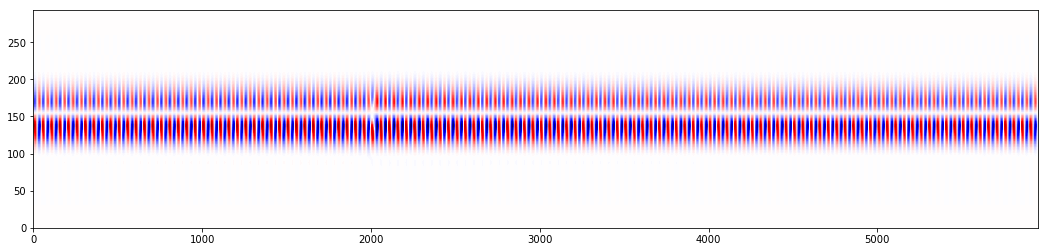

In [37]:
plt.figure(figsize=(18, 4))
plot_data = morb_planes[i_homo-1].T
max_abs = np.max(np.abs(plot_data))
plt.pcolormesh(plot_data, cmap='seismic', vmax=max_abs, vmin=-max_abs)
#plt.colorbar()
plt.show()

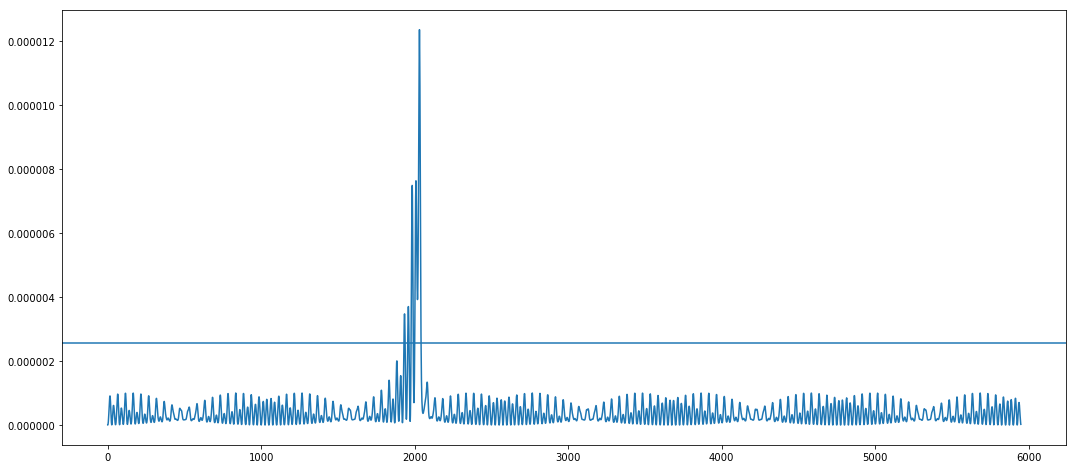

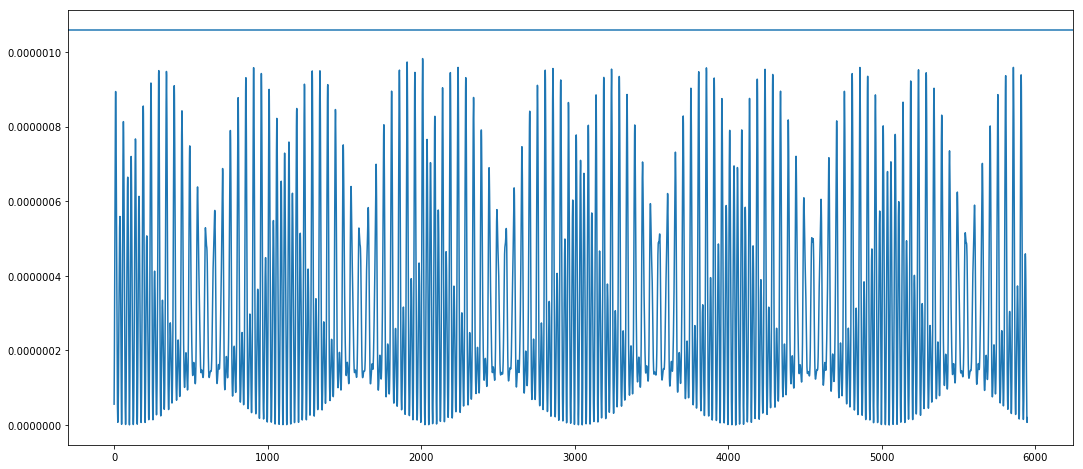

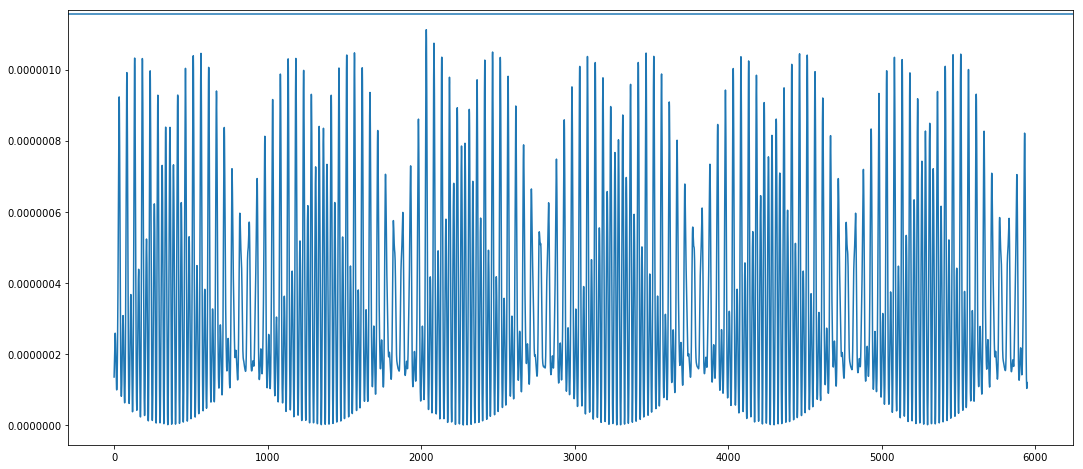

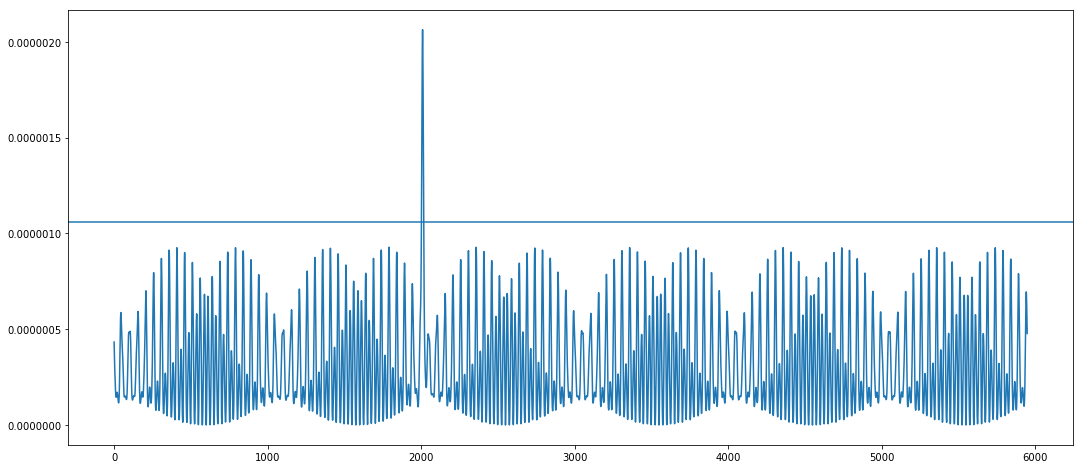

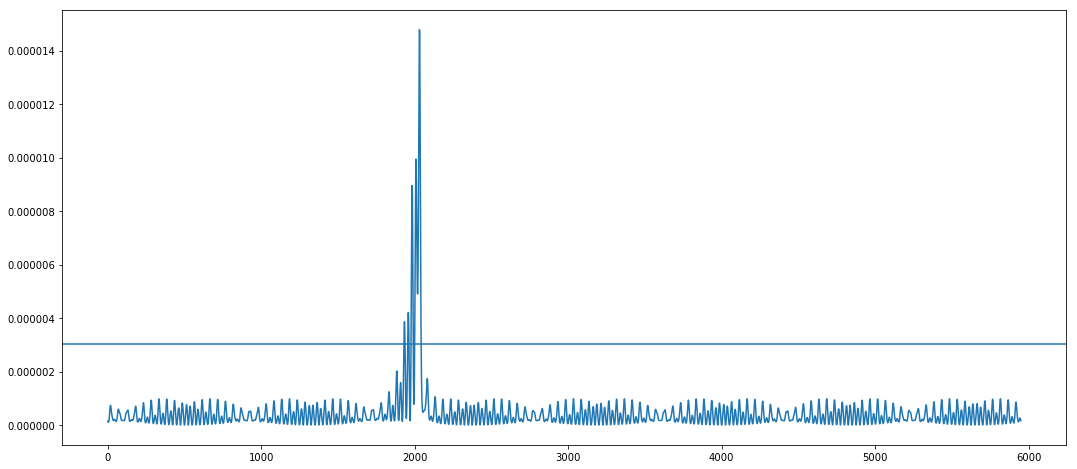

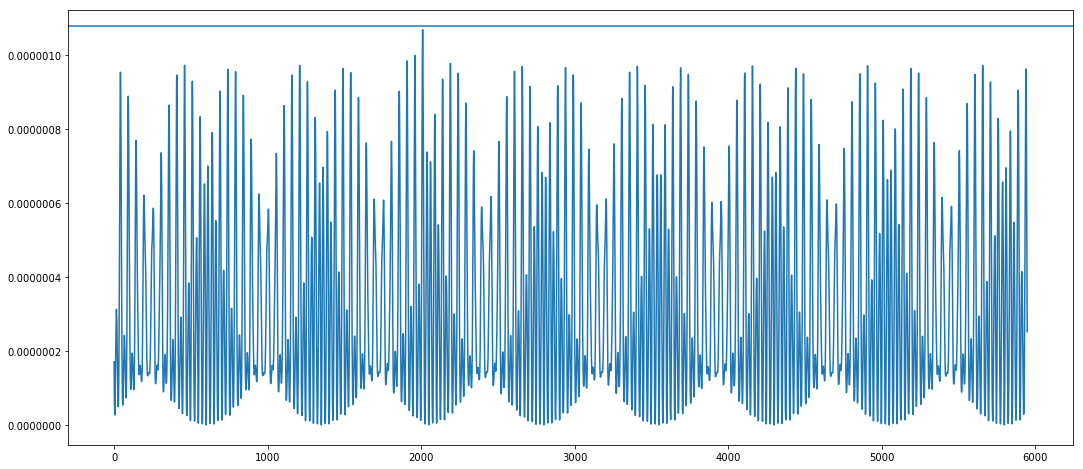

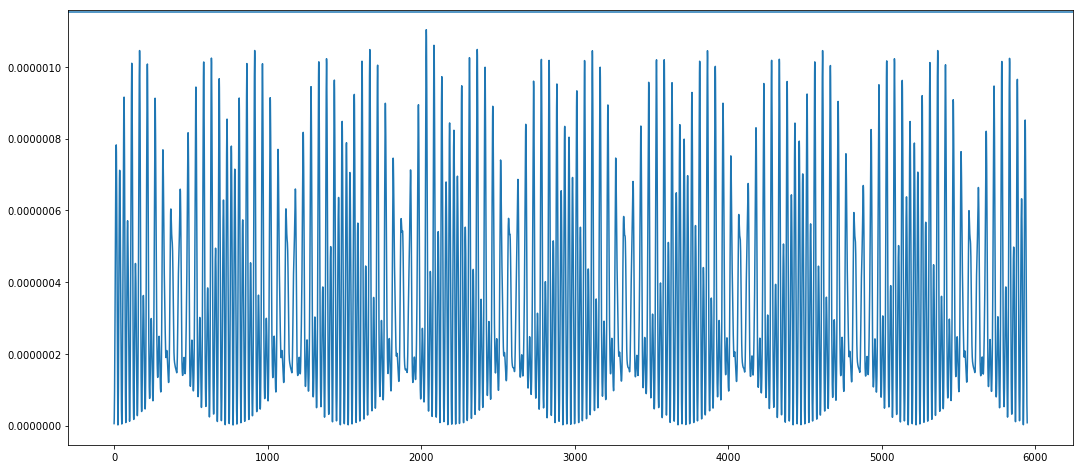

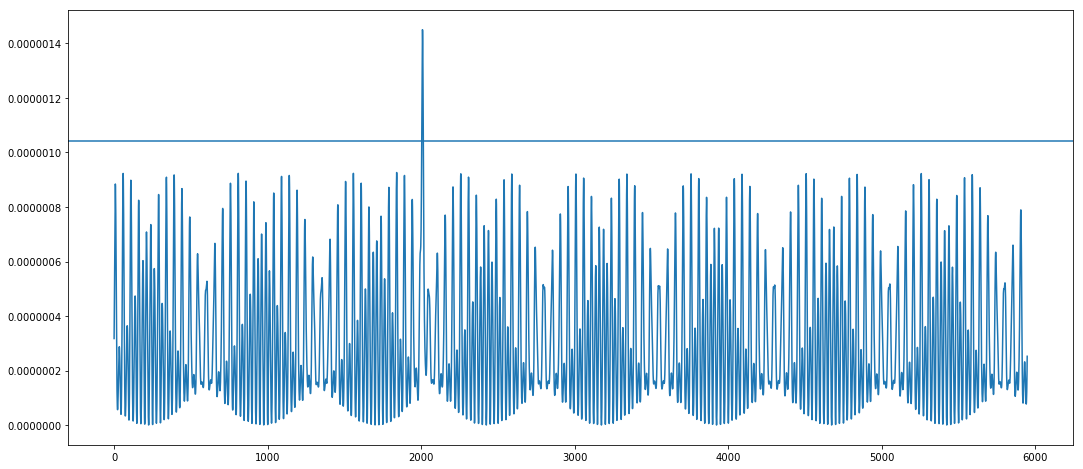

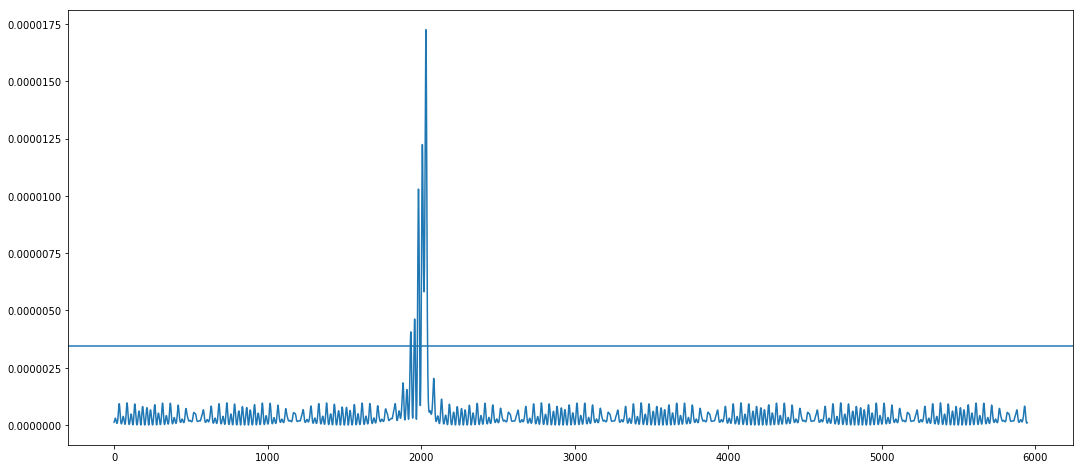

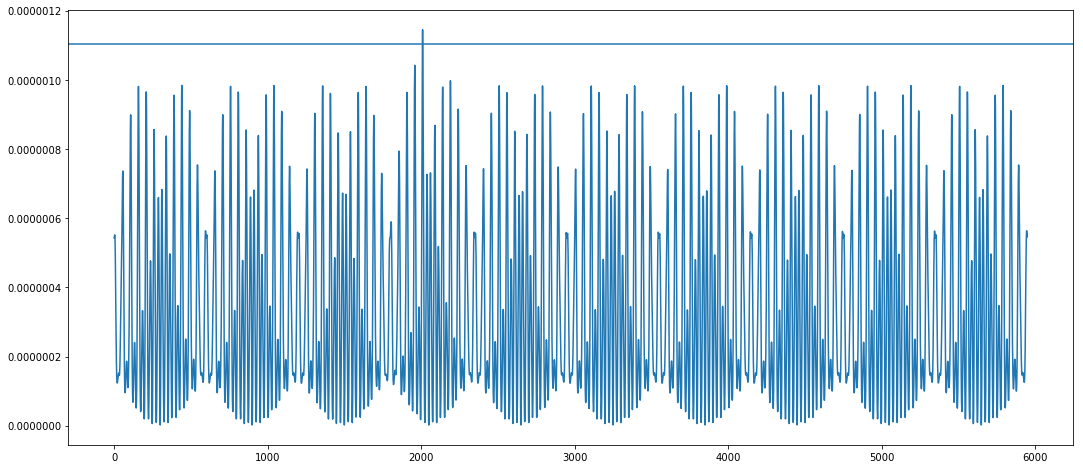

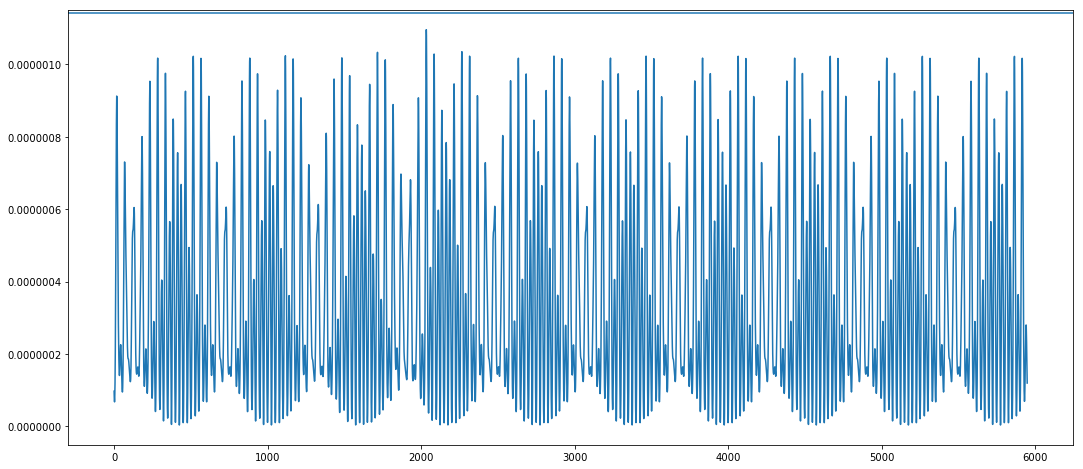

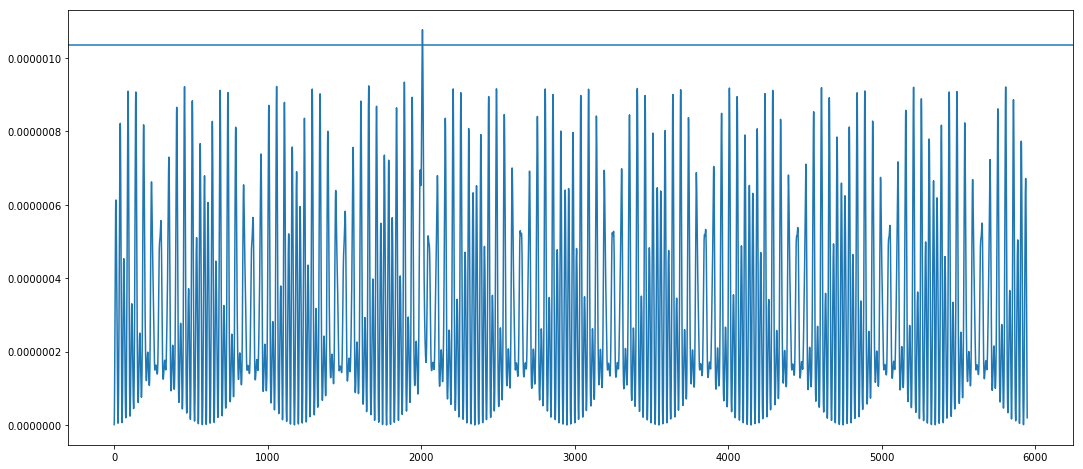

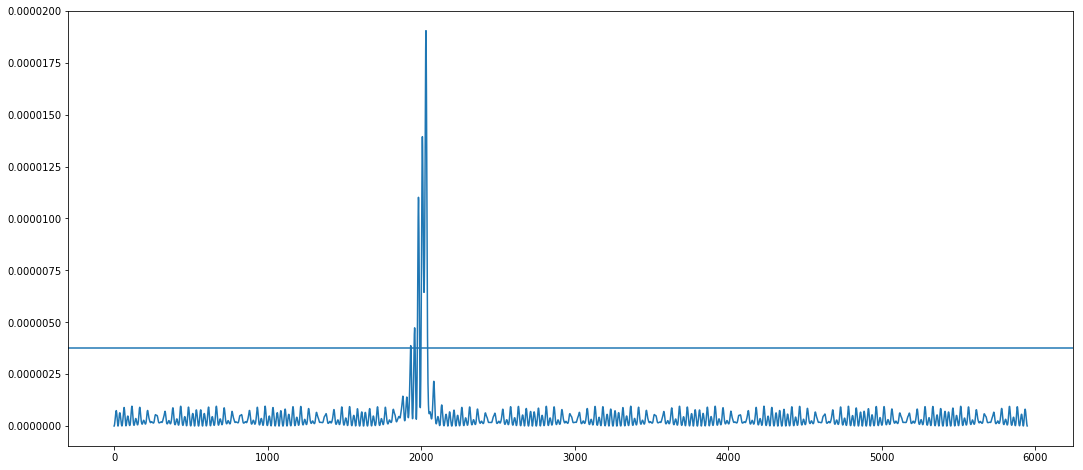

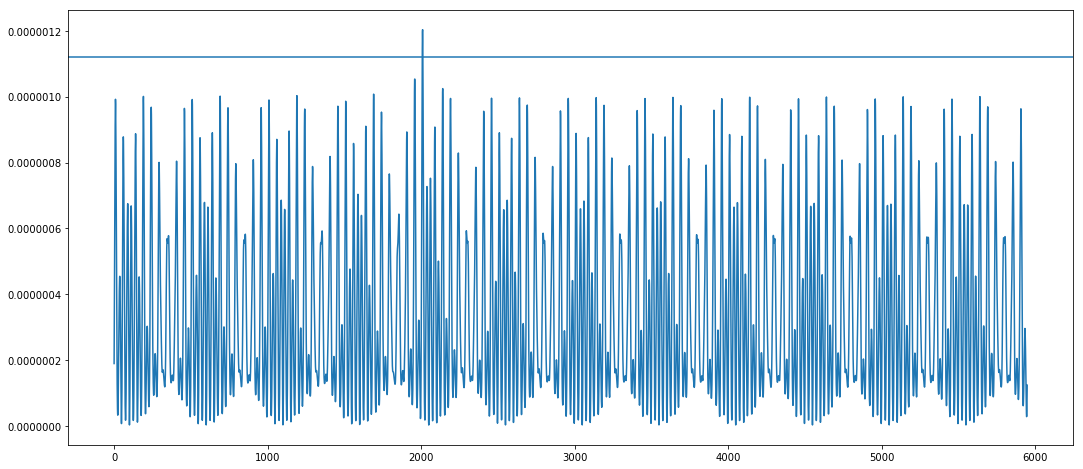

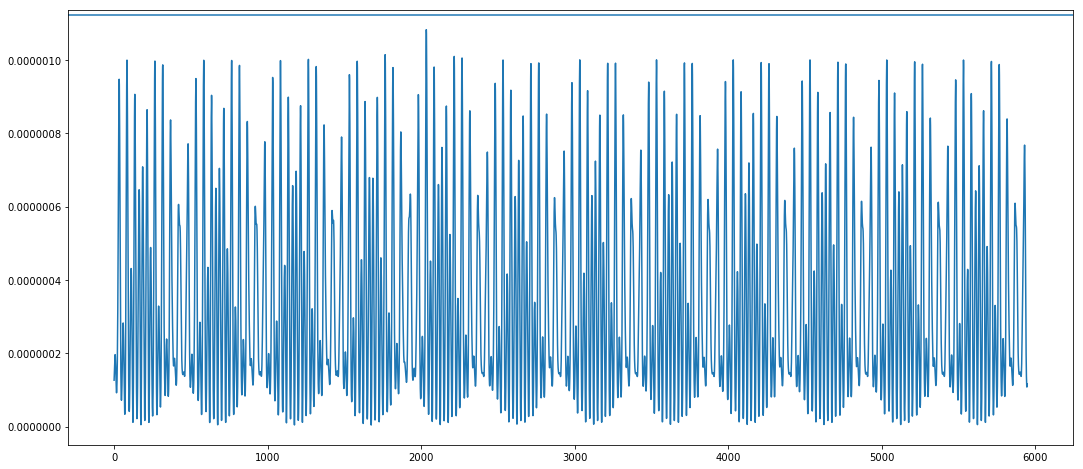

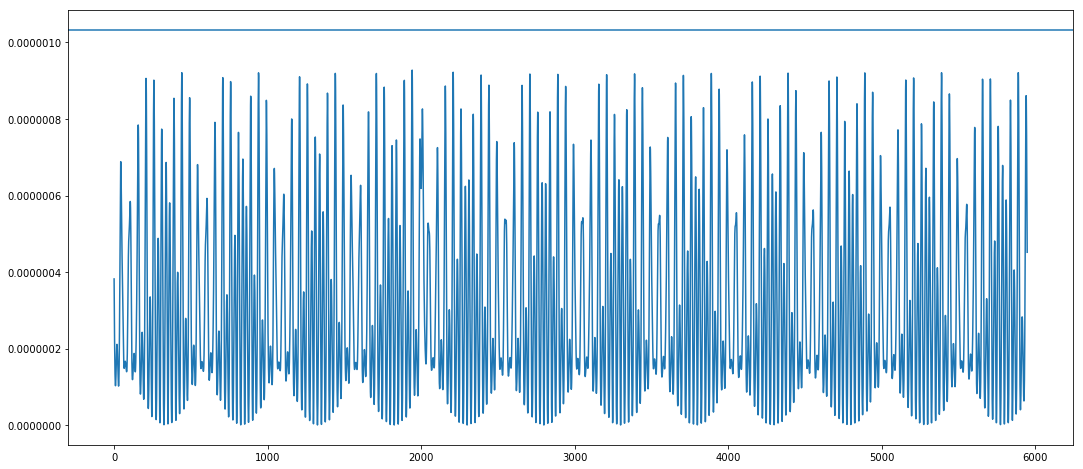

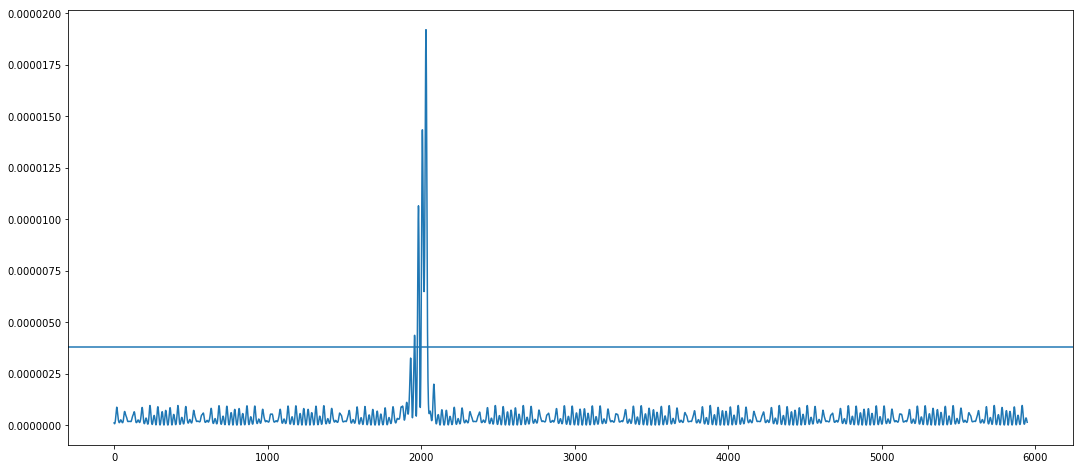

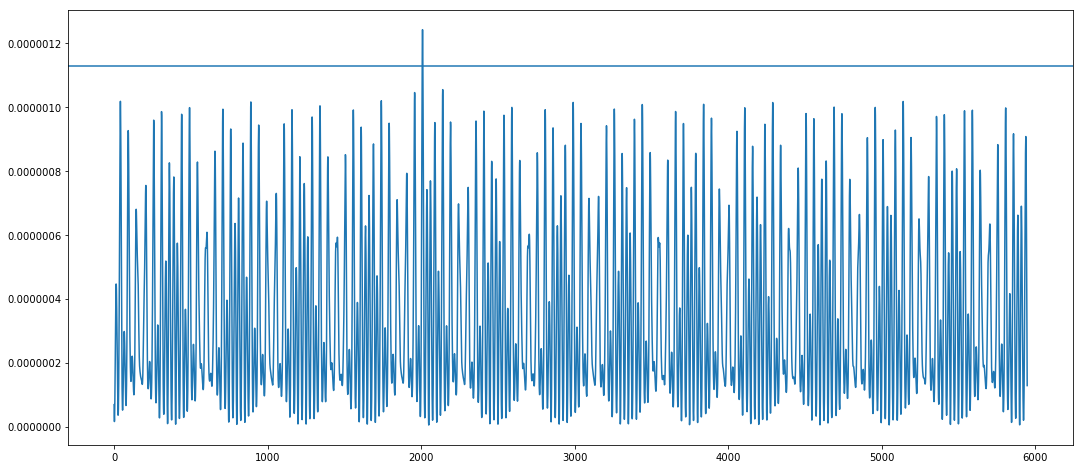

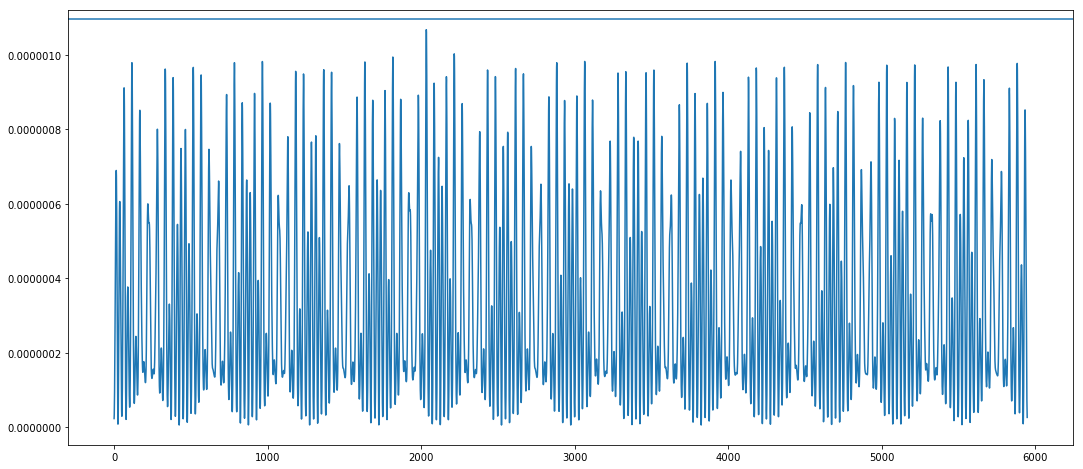

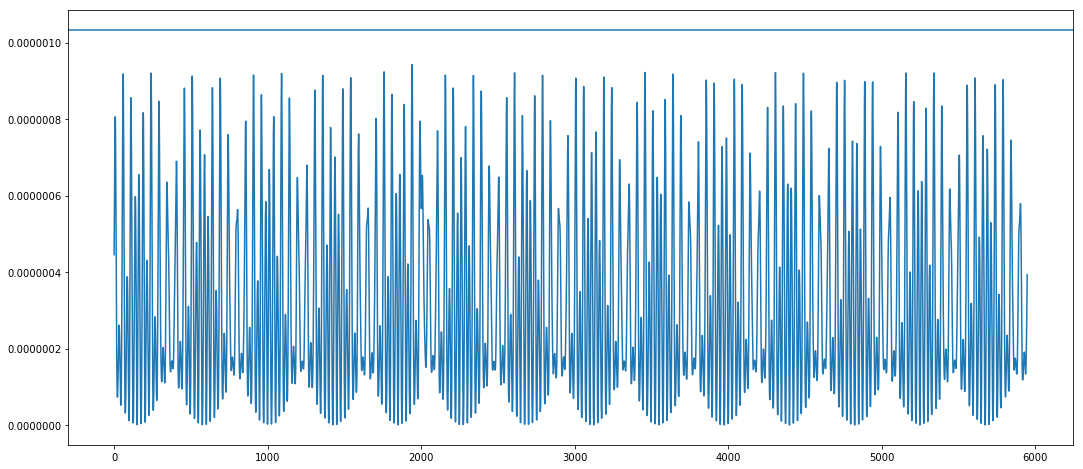

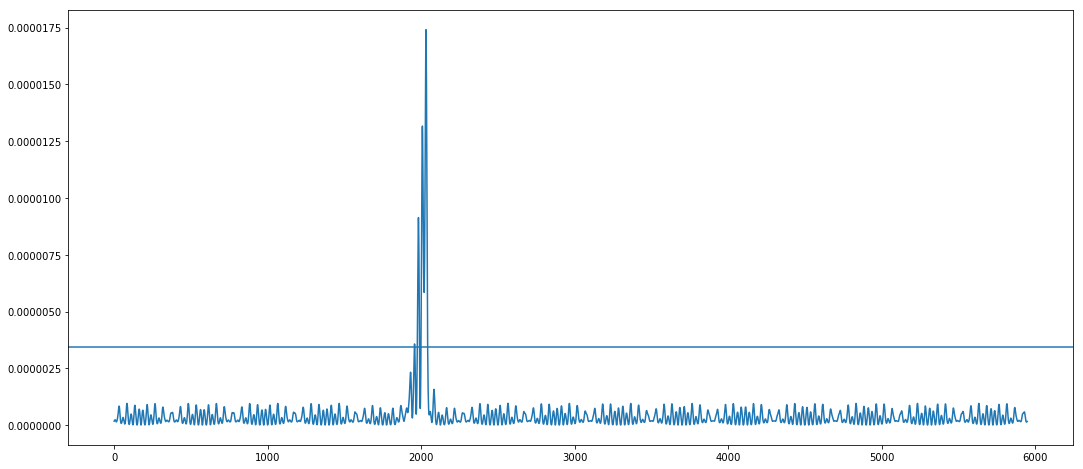

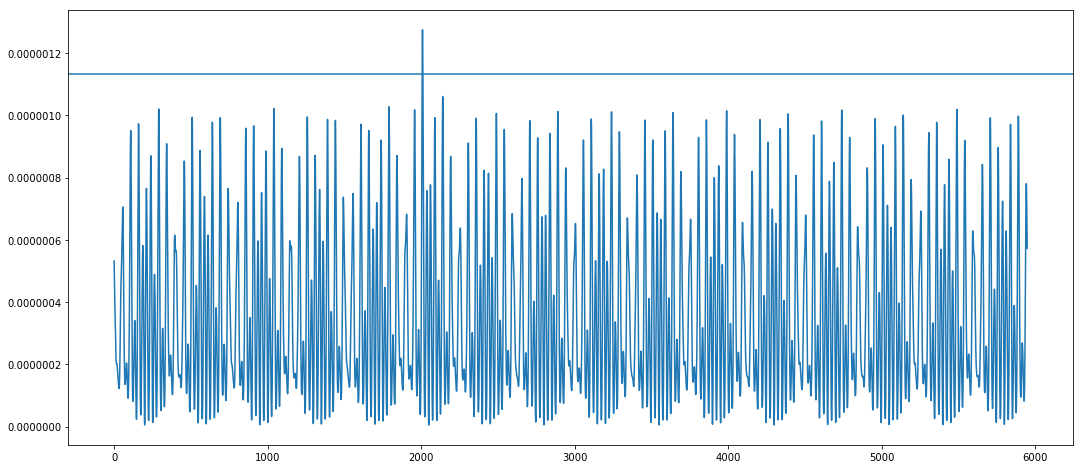

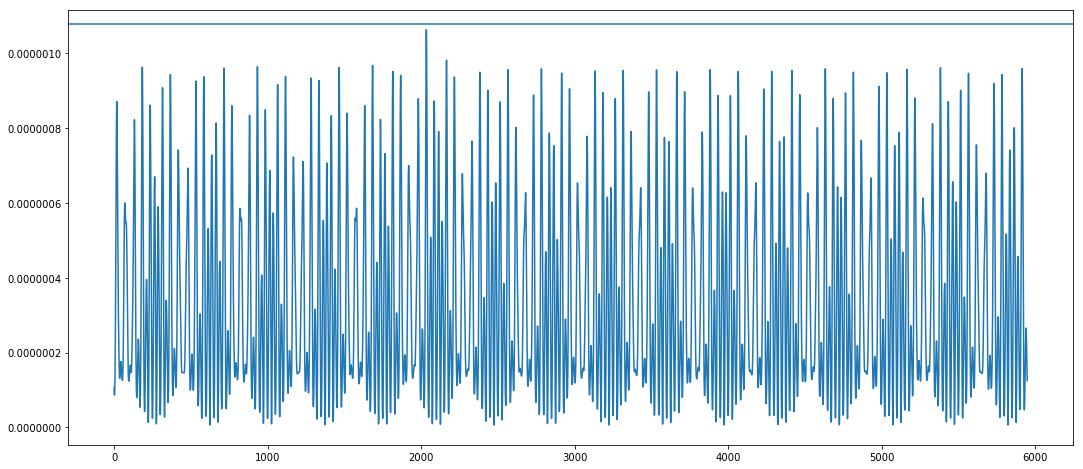

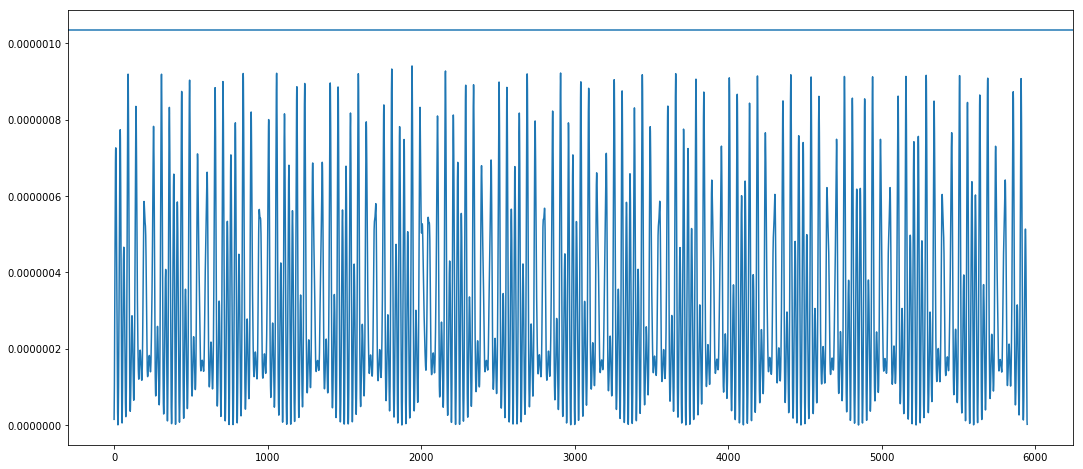

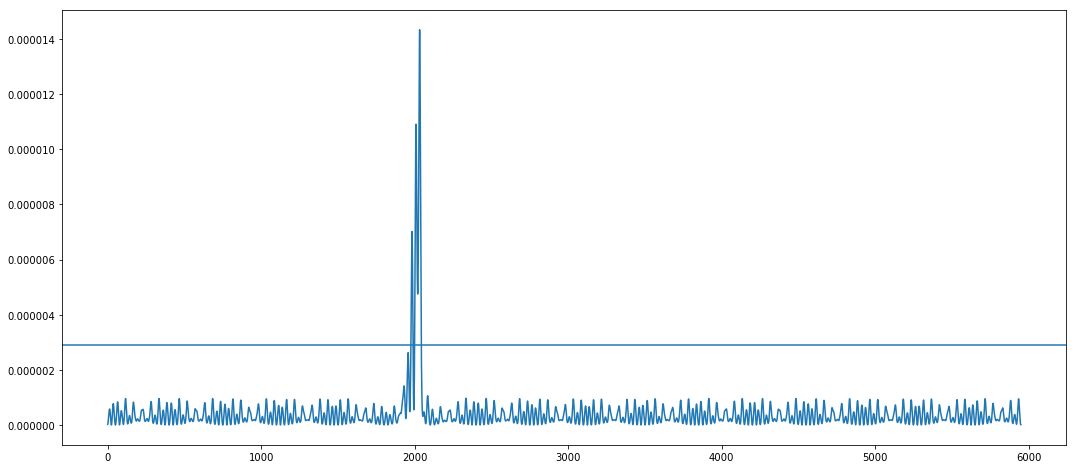

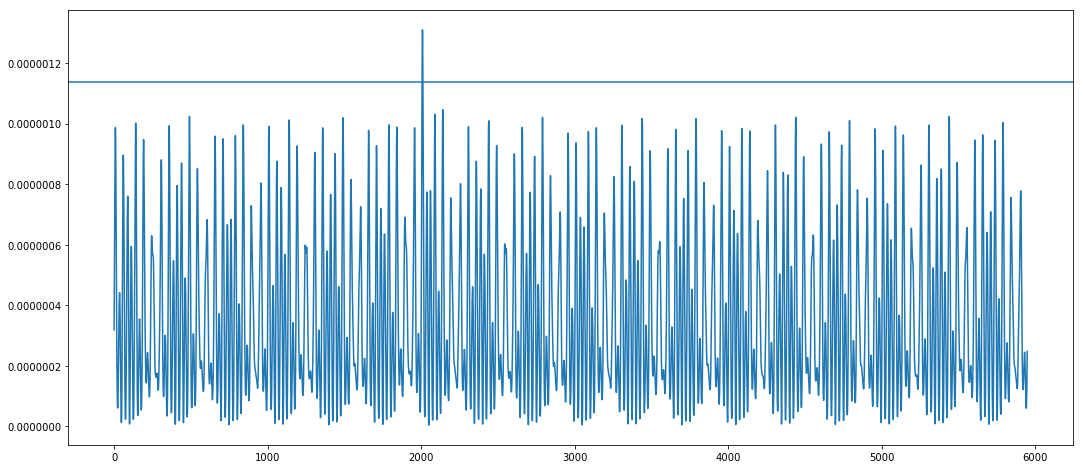

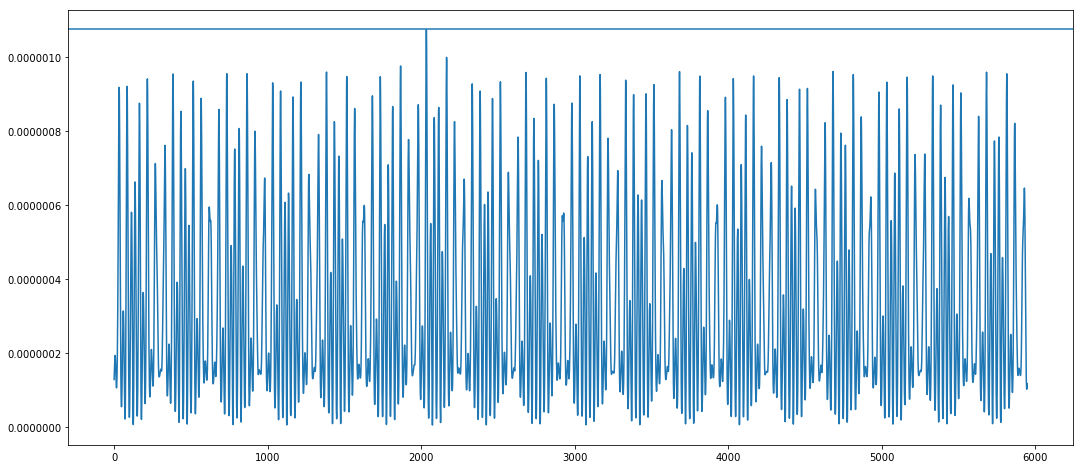

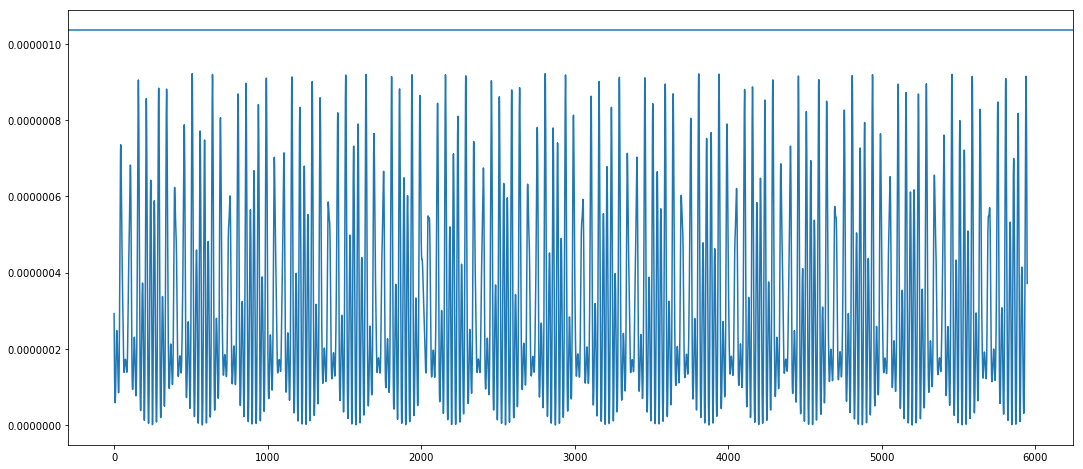

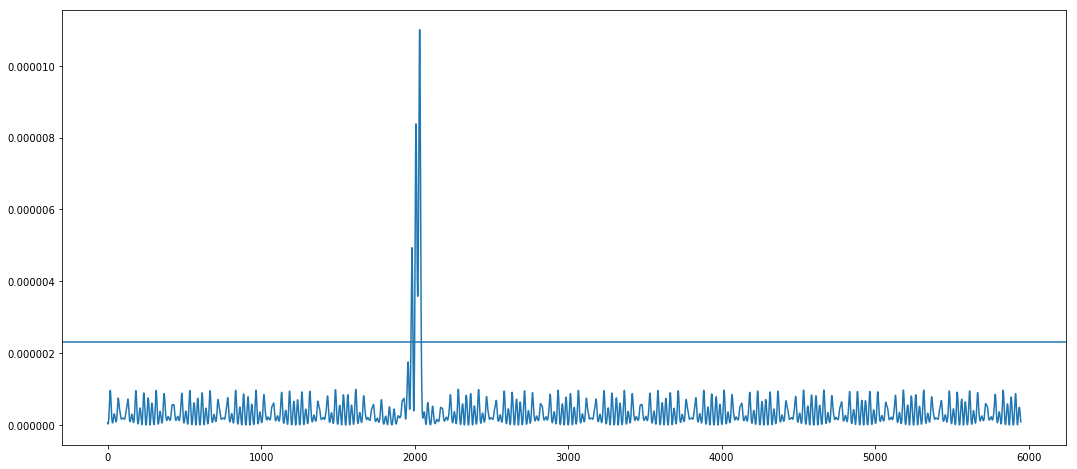

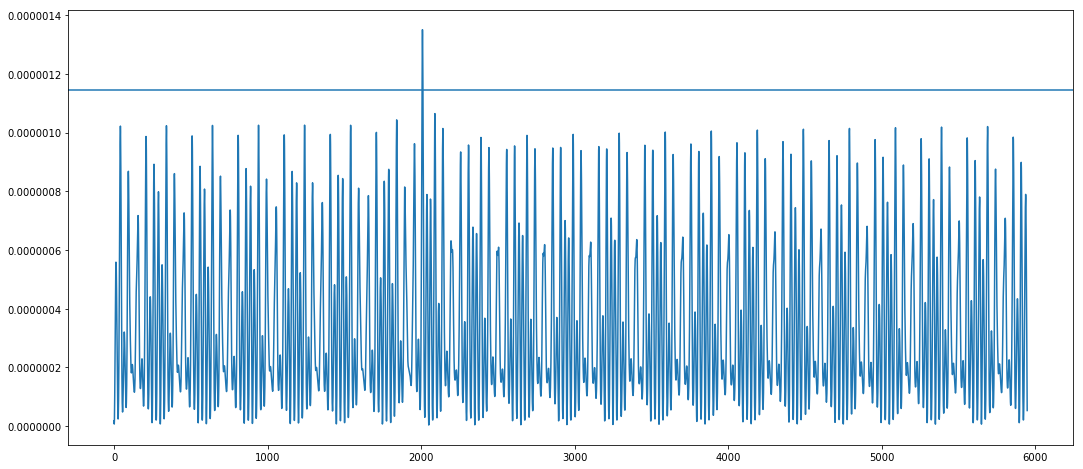

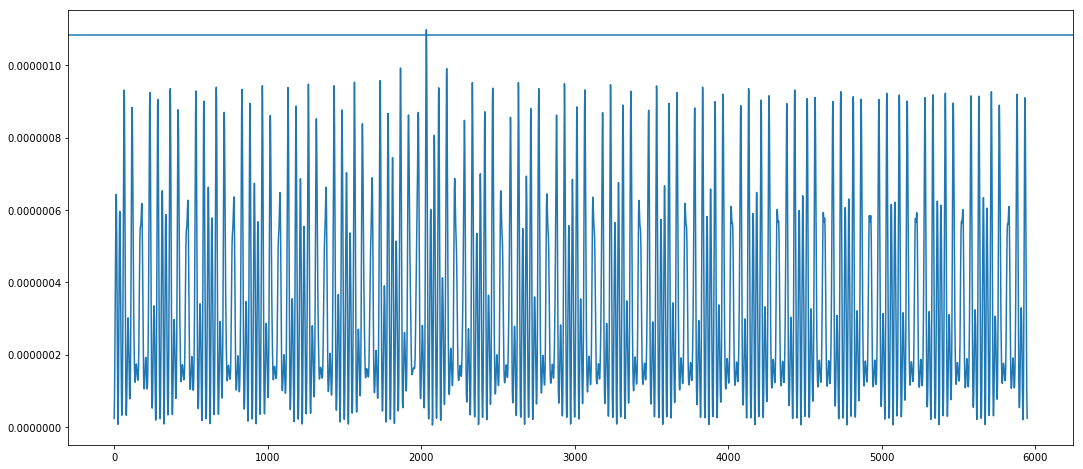

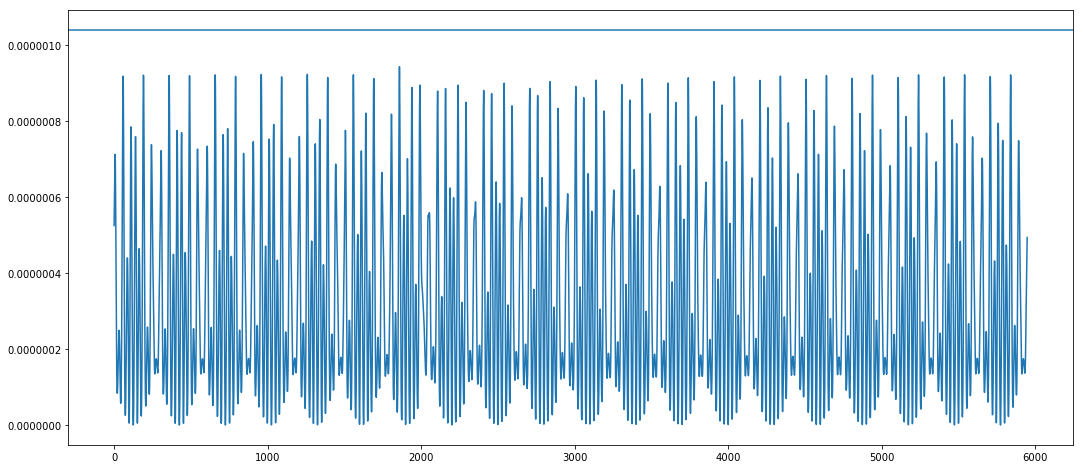

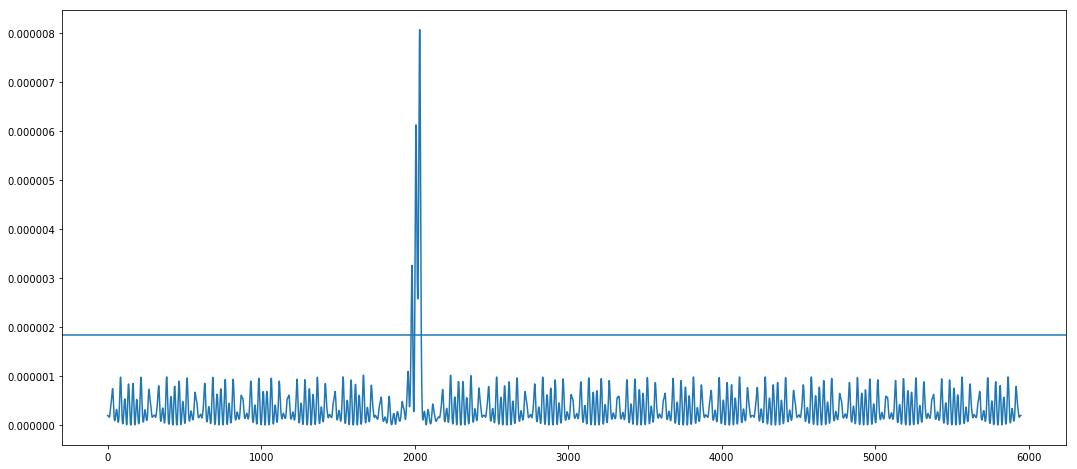

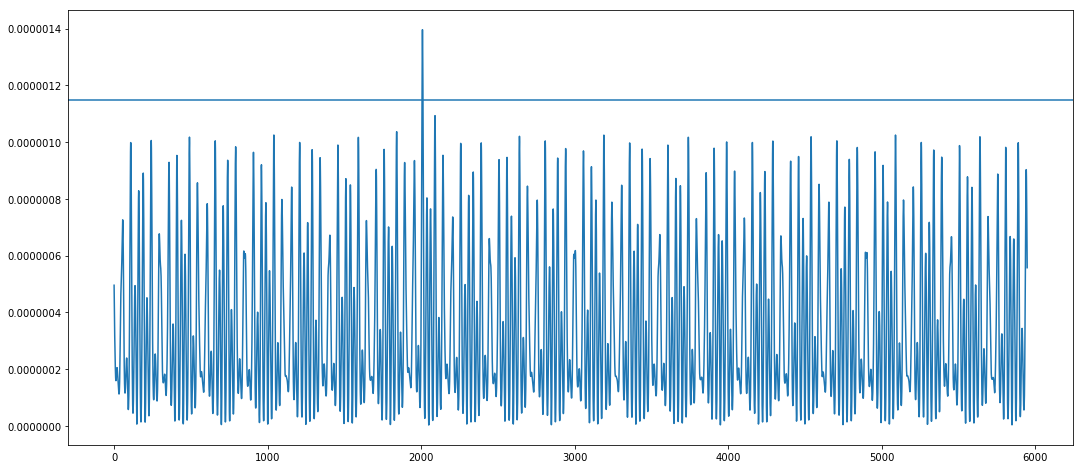

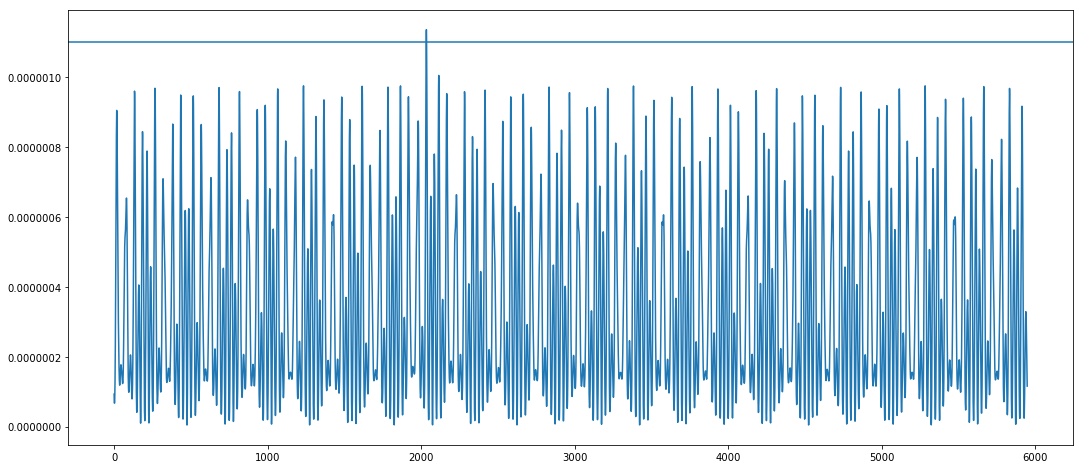

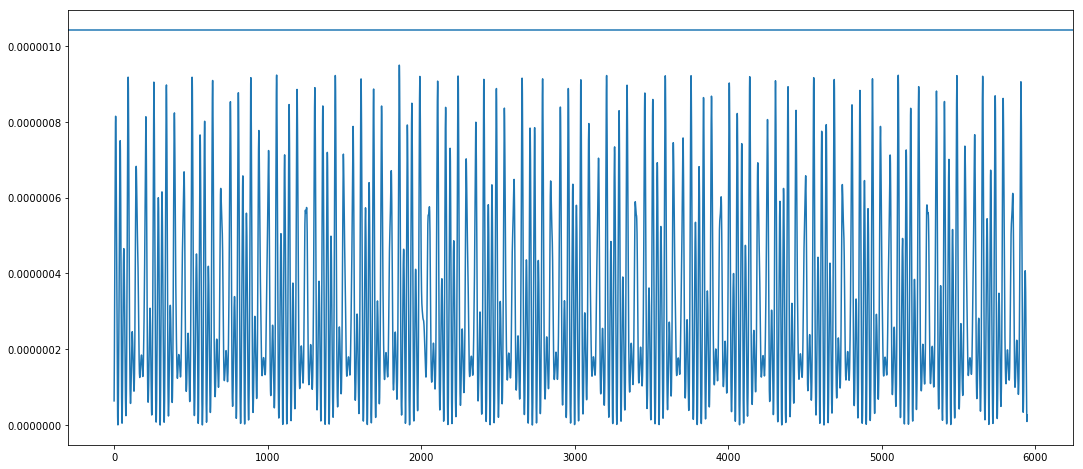

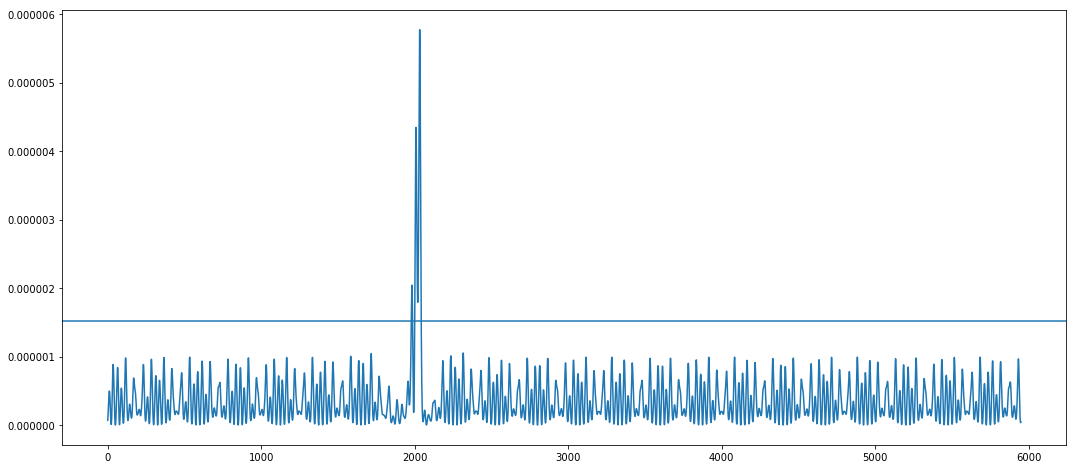

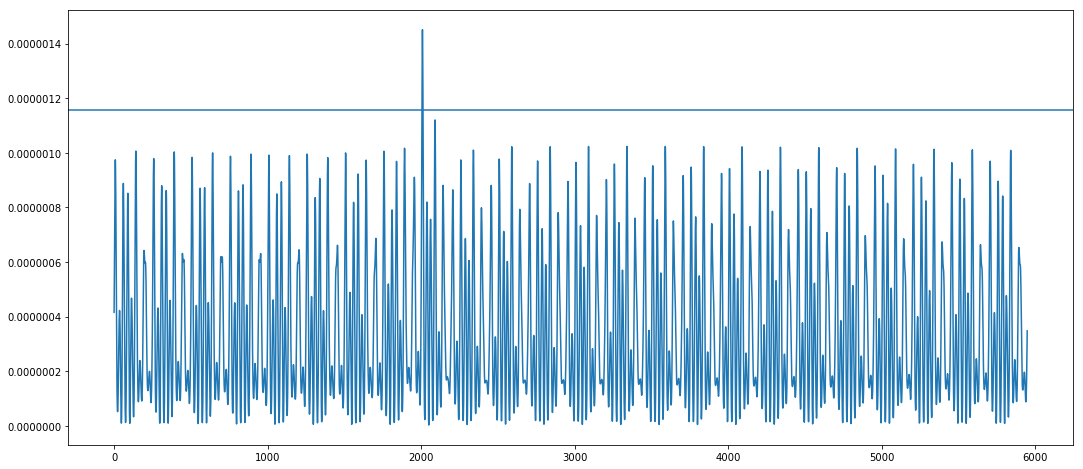

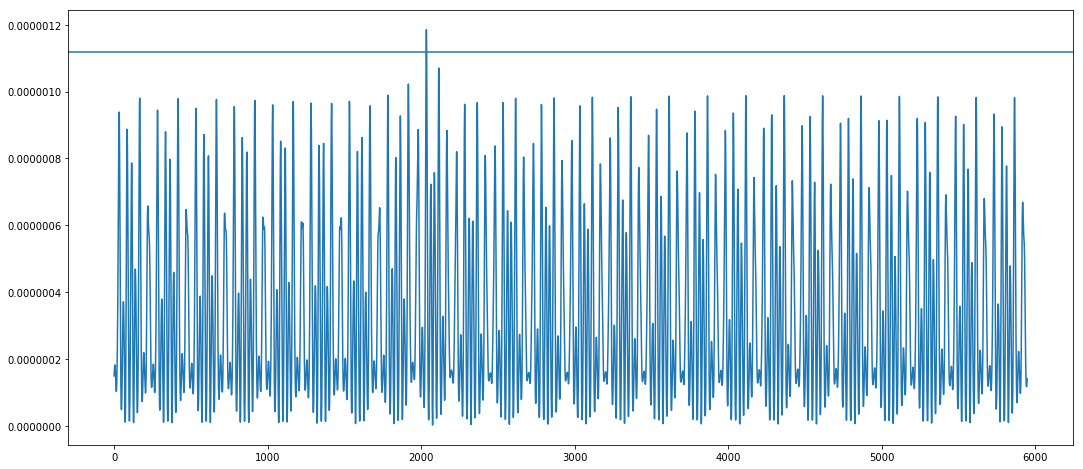

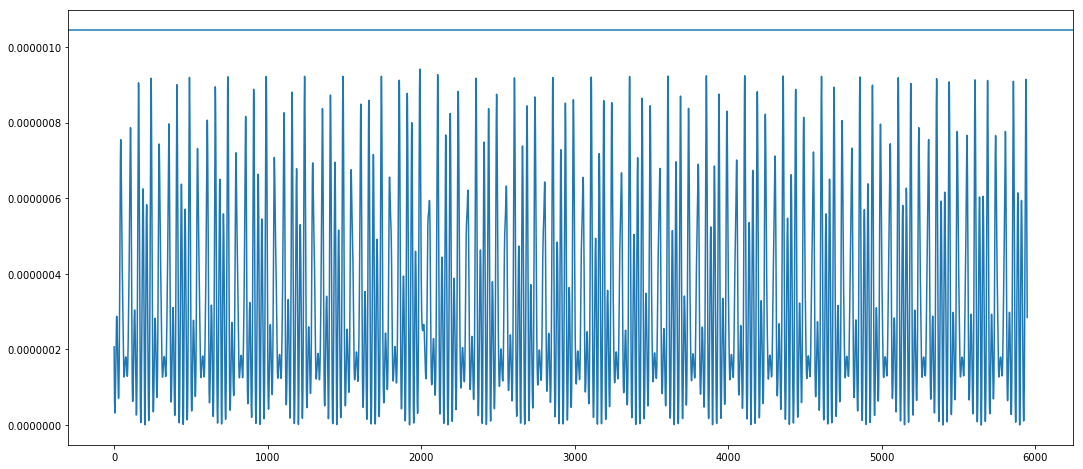

In [38]:
for i in range(10, 50):
    plt.figure(figsize=(18, 8))
    plot_data = np.mean(morb_planes[i_homo-i]**2, axis=1).T
    plt.plot(plot_data)
    plt.axhline(np.mean(plot_data)+3*np.std(plot_data))
    #plt.colorbar()
    plt.show()

In [39]:
print(morb_energies[i_homo+3])
print(morb_energies[i_homo+2])
print(morb_energies[i_homo+1])
print(morb_energies[i_homo])
print(morb_energies[i_homo-1])
print(morb_energies[i_homo-2])

0.0468335677538
0.0347383354142
0.0193696694394
-0.01565088422
-0.0264786411995
-0.0570087695503


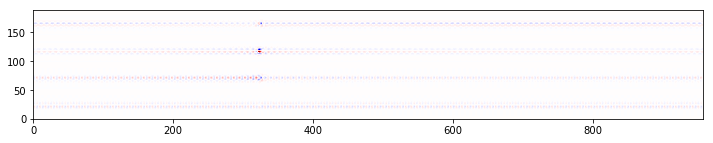

In [40]:
select = [i_homo - 1, i_homo, i_lumo, i_lumo + 1]

sel_morbs = np.zeros((cell_n[0], 4*cell_n[1]))

for i, i_mo in enumerate(select):
    sel_morbs[:, i*cell_n[1]:(i+1)*cell_n[1]] = morb_planes[i_mo]
    
y_arr_inc = np.arange(0, 4*cell[1], dv[1])

x_grid_inc, y_grid_inc = np.meshgrid(x_arr, y_arr_inc, indexing='ij')

max_val = np.max(sel_morbs)

plt.figure(figsize=(12, int(cell[1]/cell[0]*12*4)))
plt.pcolormesh(x_grid_inc, y_grid_inc, sel_morbs, vmax=max_val, vmin=-max_val, cmap='seismic') # seismic bwr
#plt.axvline(np.max(x_grid_inc)/2)
plt.show()

In [41]:
#de = 0.01 # eV
de = 0.002 # eV
        
e_arr = np.arange(emin, emax+de, de)

x_arr_ang = x_arr / ang_2_bohr

x_e_grid, e_grid = np.meshgrid(x_arr_ang, e_arr, indexing='ij')

def calculate_ldos(de, fwhm, broad_type):

    def lorentzian(x):
        gamma = 0.5*fwhm
        return gamma/(np.pi*(x**2+gamma**2))

    def gaussian(x):
        sigma = fwhm/2.3548
        return np.exp(-x**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))

    pldos = np.zeros((cell_n[0], len(e_arr)))

    for i_mo, morb_plane in enumerate(morb_planes):
        en = morb_energies[i_mo]
        avg_morb = np.mean(morb_plane**2, axis=1)

        if broad_type == 'l':
            morb_ldos_broad = np.outer(avg_morb, lorentzian(e_arr - en))
        else:
            morb_ldos_broad = np.outer(avg_morb, gaussian(e_arr - en))

        pldos += morb_ldos_broad
    
    return pldos


In [42]:
geom_name = file_xyz.split('/')[-1].split('.')[0]
ofolder = "/home/kristjan/local_work/cnt_molog_ldos/new/"

fwhm_arr = [0.01, 0.05] # eV

for fwhm in fwhm_arr:
    for broad_type in ['g']:
        
        pldos = calculate_ldos(de, fwhm, broad_type)
    
        ofname = ofolder + "ldos_%s_h%.1f_fwhm%.2f%s.txt" % (geom_name, height, fwhm, broad_type)
        header = "geom: %s; height(ang): %.1f; fwhm(eV): %.4f; broad: %s; " % (geom_name, height, fwhm, broad_type) + \
                 "xmin(ang): %.5f; xmax(ang): %.5f; nx: %d; " % (np.min(x_arr_ang), np.max(x_arr_ang), len(x_arr_ang)) + \
                 "emin(eV): %.5f; emax(eV): %.5f; ne: %d" % (np.min(e_arr), np.max(e_arr), len(e_arr))
        np.savetxt(ofname, pldos, header=header, fmt="%.4e")

## Post-processing (recent stuff in the other notebook)

In [31]:
xzero_l = 230.0
xzero_r = 230.0

nzero_l = int(np.round(xzero_l/dx))
nzero_r = int(np.round(xzero_r/dx))

pldos[:nzero_l] = 0.0
pldos[-nzero_r:] = 0.0

In [53]:
# Crop from the ends!
lattice_param = 3 * 1.42

xcrop = 10.0
# align cropping, such that remaining area is a multiple of lattice param
xcrop = (np.max(x_arr_ang)-(np.max(x_arr_ang)-2*xcrop)//lattice_param*lattice_param)/2

surp = False

ncrop_l = int(np.round(xcrop/dx))
ncrop_r = int(np.round(xcrop/dx))

pldos_cropped = np.copy(pldos[ncrop_l:-ncrop_r])
x_e_grid_cropped = x_e_grid[ncrop_l:-ncrop_r]
e_grid_cropped = e_grid[ncrop_l:-ncrop_r]

max_val = np.max(pldos_cropped)

# Surpress regions:
#xsurp = [(220, 230), (300, 310)]
#for sr in xsurp:
#    surp = True
#    nsurp_l = int(np.round((sr[0]-xcrop)/dx))
#    nsurp_r = int(np.round((sr[1]-xcrop)/dx))
#    (pldos_cropped[nsurp_l:nsurp_r])[pldos_cropped[nsurp_l:nsurp_r] > 0.1*max_val] = 0.1*max_val

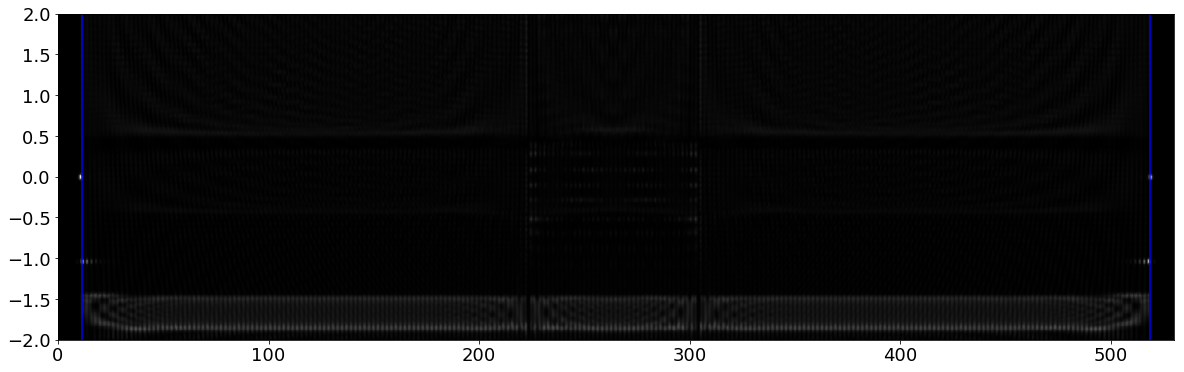

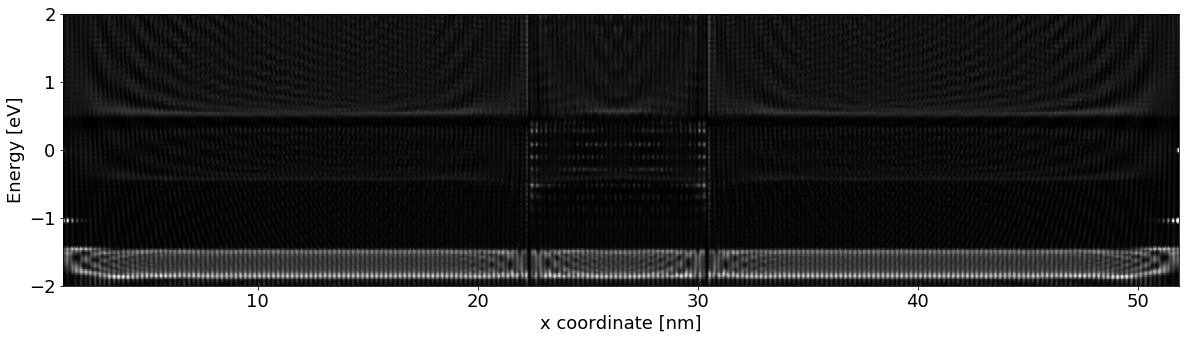

In [54]:
elim = (-2.0, 2.0)

geom_name = file_xyz.split("/")[-1].split(".")[0]

fig_folder = "./fig/h%.1f/" % height
fig_name = geom_name + "_c%d" % int(xcrop)
if surp:
    fig_name += "_sr"

e_i = (np.array((elim[0]-np.min(e_grid), elim[1]-np.max(e_grid)))/de).astype(int)
if e_i[0] < 0:
    e_i[0] = 0
if e_i[1] >= 0:
    e_i[1] = len(x_e_grid[0])

plt.figure(figsize=(20, 6))
plt.pcolormesh(x_e_grid[:, e_i[0]:e_i[1]],
               e_grid[:, e_i[0]:e_i[1]],
               pldos[:, e_i[0]:e_i[1]], cmap='gray')
# plot cropping and surpression lines
plt.axvline(x_e_grid[ncrop_l][0], color='b')
plt.axvline(x_e_grid[-ncrop_r][0], color='b')
if surp:
    for sr in xsurp:
        plt.axvline(sr[0], color='r')
        plt.axvline(sr[1], color='r')
        

plt.savefig(fig_folder+fig_name+"_ldos_whole.png", dpi=300, bbox_inches='tight')
plt.show()

matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(20, 5))

max_val = np.max(pldos_cropped[:, e_i[0]:e_i[1]])

plt.pcolormesh(x_e_grid_cropped[:, e_i[0]:e_i[1]]/10,
               e_grid_cropped[:, e_i[0]:e_i[1]],
               pldos_cropped[:, e_i[0]:e_i[1]], vmax=0.45*max_val, cmap='gray')
plt.ylabel('Energy [eV]')
plt.xlabel('x coordinate [nm]')
plt.savefig(fig_folder+fig_name+"_ldos.png", dpi=300, bbox_inches='tight')
plt.show()

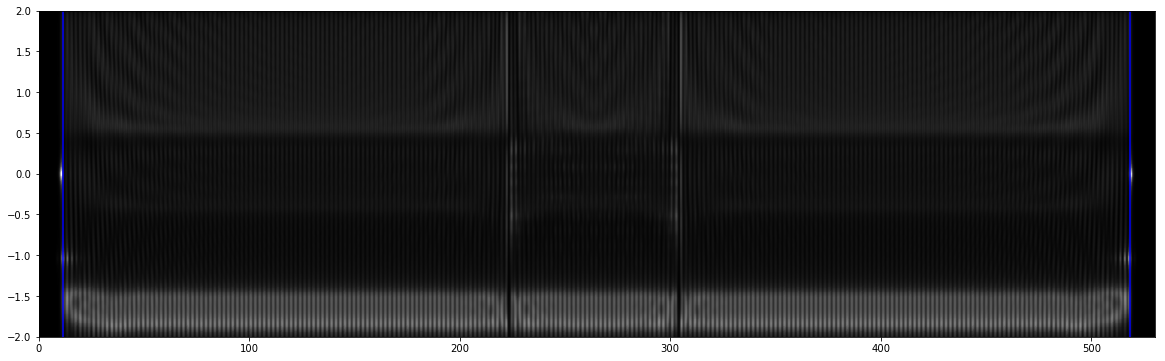

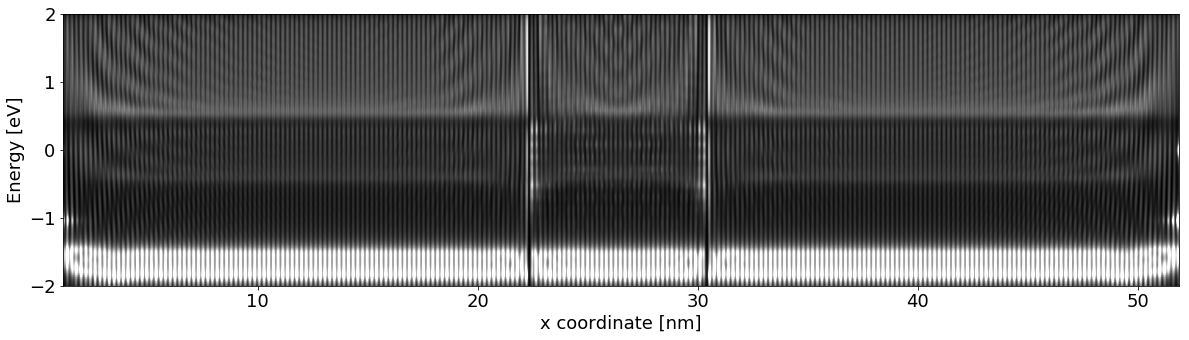

In [41]:
elim = (-2.0, 2.0)

geom_name = file_xyz.split("/")[-1].split(".")[0]

fig_folder = "./fig/h%.1f/" % height
fig_name = geom_name + "_c%d" % int(xcrop)
if surp:
    fig_name += "_sr"

e_i = (np.array((elim[0]-np.min(e_grid), elim[1]-np.max(e_grid)))/de).astype(int)
if e_i[0] < 0:
    e_i[0] = 0
if e_i[1] >= 0:
    e_i[1] = len(x_e_grid[0])

plt.figure(figsize=(20, 6))
plt.pcolormesh(x_e_grid[:, e_i[0]:e_i[1]],
               e_grid[:, e_i[0]:e_i[1]],
               pldos[:, e_i[0]:e_i[1]], cmap='gray')
# plot cropping and surpression lines
plt.axvline(x_e_grid[ncrop_l][0], color='b')
plt.axvline(x_e_grid[-ncrop_r][0], color='b')
if surp:
    for sr in xsurp:
        plt.axvline(sr[0], color='r')
        plt.axvline(sr[1], color='r')
        

plt.savefig(fig_folder+fig_name+"_ldos_whole.png", dpi=300, bbox_inches='tight')
plt.show()

matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(20, 5))

max_val = np.max(pldos_cropped[:, e_i[0]:e_i[1]])

plt.pcolormesh(x_e_grid_cropped[:, e_i[0]:e_i[1]]/10,
               e_grid_cropped[:, e_i[0]:e_i[1]],
               pldos_cropped[:, e_i[0]:e_i[1]], vmax=0.45*max_val, cmap='gray')
plt.ylabel('Energy [eV]')
plt.xlabel('x coordinate [nm]')
plt.savefig(fig_folder+fig_name+"_ldos.png", dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# in k-space

ft = np.fft.rfft(pldos_cropped, axis=0)
aft = np.abs(ft)


# Corresponding k points
k_arr = 2*np.pi*np.fft.rfftfreq(len(pldos_cropped[:, 0]), dx)
# Note: Since we took the FT of the charge density, the wave vectors are
#       twice the ones of the underlying wave function.
k_arr = k_arr / 2

n_k = len(aft[:, 0])

# Following has slight incorrect shift
#kmin = 0.0
#kmax = np.pi / dx
#kmax = kmax / 2
#k_arr = np.linspace(kmin, kmax, n_k)

k_grid, e_k_grid = np.meshgrid(k_arr, e_arr, indexing='ij')

# Lattice spacing for the ribbon = 3x c-c distance
# Brillouin zone boundary [1/angstroms]
bzboundary = np.pi / (3 * 1.42)

dk = k_arr[1]
bzb_i = int(np.round(bzboundary/dk))+1


NameError: name 'pldos_cropped' is not defined

In [35]:
def fold_bands(aft, k_arr, e_arr, bzboundary):
    
    dk = k_arr[1]
    bzb_i = int(np.round(bzboundary/dk))+1
    
    bz1_aft = np.zeros(np.shape(aft[:bzb_i]))
    bz1_kgrid, bz1_egrid = np.meshgrid(k_arr[:bzb_i], e_arr, indexing='ij')
    
    for ind, k_aft in enumerate(aft):
        k_val = k_arr[ind]
        bz_nr = int(k_val // bzboundary)
        frac_k = k_val % bzboundary
        if bz_nr % 2 == 0:
            k_folded = frac_k
        else:
            k_folded = bzboundary - frac_k
        
        bz1_ind = int(np.round(k_folded/dk))
        bz1_aft[bz1_ind, :] += k_aft
                       
        
    return bz1_aft, bz1_kgrid, bz1_egrid
        

bz1_aft, bz1_kgrid, bz1_egrid = fold_bands(aft, k_arr, e_arr, bzboundary)

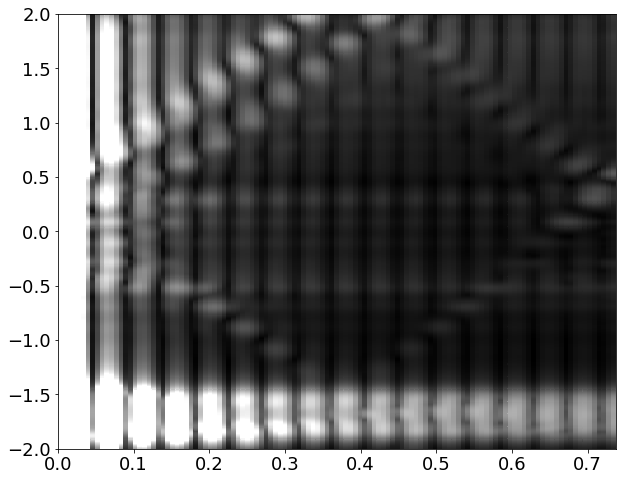

In [38]:
# NB: when plotting, the k and e grids corresponds to edges of the cells,
#     real data corresponds to middle points

plt.figure(figsize=(10, 8))

max_val = np.max(aft[:bzb_i, e_i[0]:e_i[1]])

plt.pcolormesh(bz1_kgrid[e_i[0]:e_i[1]],
               bz1_egrid[e_i[0]:e_i[1]],
               bz1_aft[e_i[0]:e_i[1]],
               vmax=0.07*max_val, cmap='gray')
plt.xlim([0.0, bzboundary])
plt.savefig(fig_folder+fig_name+"_ftsts.png", dpi=300, bbox_inches='tight')
plt.show()

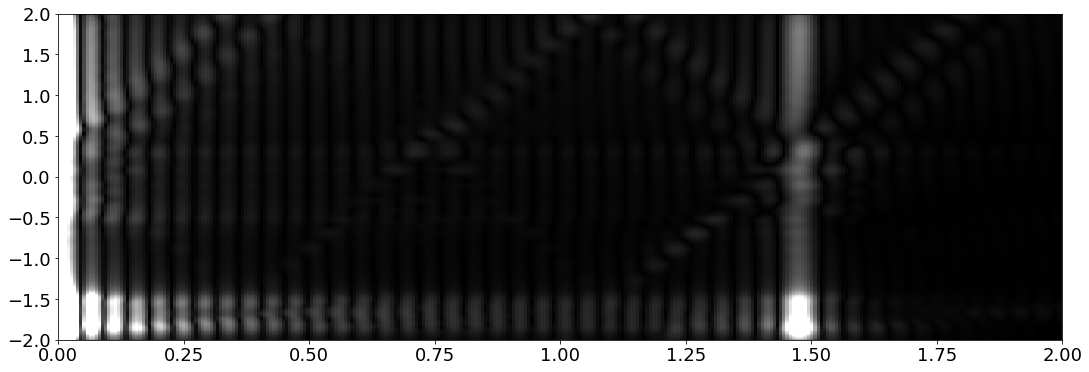

In [37]:
plt.figure(figsize=(18, 6))

max_val = np.max(aft[:, e_i[0]:e_i[1]])

plt.pcolormesh(k_grid[:, e_i[0]:e_i[1]],
               e_k_grid[:, e_i[0]:e_i[1]],
               aft[:, e_i[0]:e_i[1]],
               vmax=0.1*max_val, cmap='gray')
plt.xlim([0.0, 2.0])
plt.show()

# Together with QE bands

In [1]:
import qe_utils as qeu

In [2]:
# [[label, scf_output_file, bands_output_dir]]
datafiles = [["QE GTH unrelaxed",
              "/home/kristjan/local_work/qe_cnt_6-0_bands/scf.out",
              "/home/kristjan/local_work/qe_cnt_6-0_bands/"]]

# {'label'} = [kpts, eig_vals]
datasets = {}

for df in datafiles:
    label = df[0]
    scf_f = df[1]
    band_dir = df[2]
    kpts, eig_vals = qeu.read_and_shift_bands(scf_f, band_dir)
    datasets[label] = [kpts, eig_vals]

In [3]:
plot_info = [("QE GTH unrelaxed", '-', 'b')]

In [4]:

plt.figure(figsize=(10, 8))

max_val = np.max(aft[:bzb_i, e_i[0]:e_i[1]])

# xcrop c*maxval
# 10.0  0.01
# 50.0  0.001
# 100.0 0.001

plt.pcolormesh(k_grid[:bzb_i, e_i[0]:e_i[1]]*10,
               e_k_grid[:bzb_i, e_i[0]:e_i[1]],
               aft[:bzb_i, e_i[0]:e_i[1]],
               vmax=0.01*max_val, cmap='gray')

for pi in plot_info:
    label = pi[0]
    ls = pi[1]
    col = pi[2]
    
    kpts_raw, eig_vals = datasets[label]
    
    # Convert kpts to correct units (from QE: 0.5 corresponds to BZ edge)
    kpts = kpts_raw*bzboundary/0.5
    
    # 1/nm
    kpts *= 10
        
    for n in range(len(eig_vals[0])):
        if n == 0:
            plt.plot(np.abs(kpts[:, 0]), eig_vals[:, n], linestyle=ls, color=col, linewidth=0.5, label="QE bands")
        else:
            plt.plot(np.abs(kpts[:, 0]), eig_vals[:, n], linestyle=ls, color=col, linewidth=0.5)
            
    
plt.axhline(0.0, linestyle='--', color='k')
plt.xlim([0.0, bzboundary*10])
plt.ylim([-2, 2])
#plt.legend(loc='upper right')
plt.ylabel('$E-E_F$ [eV]')
plt.xlabel('k [nm$^{-1}$]')
#plt.savefig("./fig/"+name+".pdf", bbox_inches='tight')
plt.savefig(fig_folder+fig_name+"_ftsts.png", dpi=300, bbox_inches='tight')
plt.show()


NameError: name 'plt' is not defined